In [80]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Classification.

In this chapter we will look at different classification systems.

### MNIST

MNIST dataset: is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

In [52]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

`sklearn.datasets` package contains mostly three types of functions:
* fetch_* - to download real-life datasets
* load_* - load small toy datasets bundled with Scikit_learn
* make_* - functions to generate fake datesets, useful for tests

👁️ fetch_* returns the inputs as pandas dataframes, as mnist contains images, in this case we put as_frame=False.

In [53]:
X, y = mnist.data, mnist.target


In [54]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [55]:
X.shape

(70000, 784)

In [56]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [57]:
y.shape

(70000,)

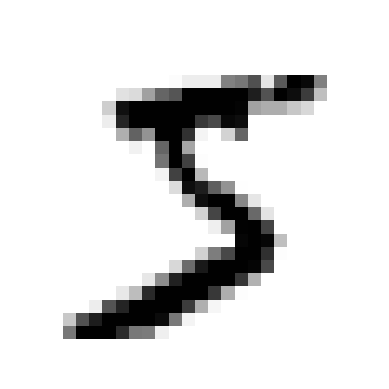

In [58]:
# Let´s show a pic converting the tensor into an image (784 == 28 x 28 pixels)
# To convert to gray scale -> cmap = binary

import matplotlib.pyplot as plt

# Create definition to plot image
def plot_digit(image_data):
  image = image_data.reshape(28,28)
  plt.imshow(image, cmap='binary')
  plt.axis('off')

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [59]:
y[0]

'5'

In [60]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

### Training a Binary Classifier

Try to identify just one digit "5"

In [61]:
# Create target vectors
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

Let's pick a Classifier and train it.

A good start could *stochastic gradient descent SGD*

`SGDClassifier`

In [62]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [63]:
sgd_clf.predict([some_digit])

array([ True])

Looks like this predicition is correct. now we need to evalute model's performance

### Performance Measures
Evaluating a classifier is iften significantly trickier than evaluating a regressor. There are many performance measures available

#### Measuring Accuracy Using Cross-Validation

In [64]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

It give us a great result! Over 95% accuracy

Let's look what happend when we try to predict when the digit is not 5

In [65]:
# using DummyClassifier
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # prints False: no 5's detected

False


In [66]:
# Let's look at the accuracy
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

Ole! Over 90%, but....
Almost 90% of the values are not 5 so if you are trying to guess if an image is not 5 you have 90% of probs that you pick a winner.

This demonstrate that accuracy is not the preferred measure for classifiers.

There is a much better way:

#### Confusion Matrix

👁️ Test set must remain untouched until the very end of the project

In [67]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [68]:
# Once we have cross validated predictions we can get the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

[[53892 True negatives, 687 False positives],<br>[1891 False negatives, 3530 True Positives]]

From confusion matrices we can get a lot of information

* Precision = TP / (TP +FP)
* Recall = Sensititvity = True Positive Rate = TP / (TP + FN)
* Specificity = TN / (TN + FP)
* False Positive Rate = 1 - Specificity = FP / (FP + TN)

In [69]:
# We can use Scikit-Learn to calculate classifier metrics, including precission and recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [70]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

So, when our model claims an image represents a 5, it is only correct 83.7% of the times.<br>
And it only detects 65,1% of 5's

##### F1_score
It is the harmonic mean of precision and recall. It takes both false positives and false negatives into account. Therefore, it perfomrs well on an imbalanced dataset.

F1_score = 2 / (1/precision + 1/recall) = 2 * (precision * recall) / (precision + recall)

In [71]:
# to compute F1_score we just only need to call f1_score function
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

"*f1_score favors classiffiers that have similar precision and recall. this is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low reacall) but keeps only safe ones (high precision), rather than a classifier that has much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier's video selection). <br>
On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier only has 30% precision as long it has 90% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught)*"

### The Precision-Recall Trade-off

Moving the threshold to one side or another of a virtual line with the score NegativePredicitions-PositivePredictions make us going in the direection of one of the two posibilities commented in the quote above. 👆

Scikit_learn does not let us set threshold in a direct way, but it give us acces to the decision scores that it uses to make predictions.

In [72]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [73]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [74]:
# Let's reaise threshold
threshold=3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decrases recall
We need now to get scores not predictions

In [75]:
# USe the croos_val_predict() to get all the scores of all instances in the training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [76]:
# Compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

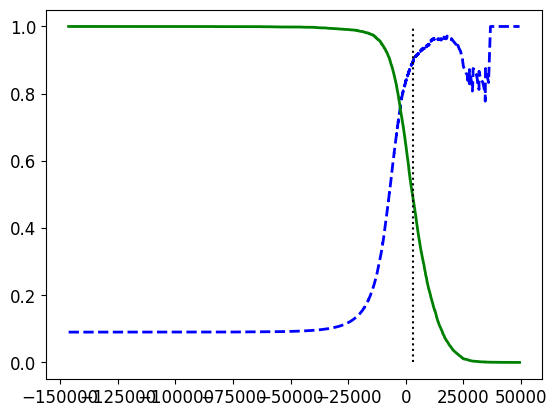

In [77]:
# Let's create a figure to interpret this values
plt.plot(thresholds, precisions[:-1], 'b--', label='precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='recalls', linewidth=2)
plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label='threshold')
plt.show()

Saving figure precision_recall_vs_threshold_plot


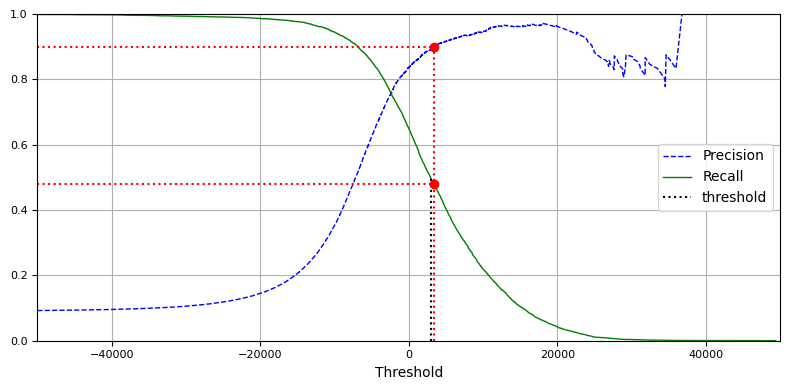

In [82]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=1)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=1)
    plt.vlines(threshold, 0, .5, 'k', 'dotted', label='threshold')
    plt.legend(loc="center right", fontsize=10) # Not shown in the book
    plt.xlabel("Threshold", fontsize=10)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()